# Random Forest Classifier 
* Grid search to find best parameters
* Cross validation
* Parameter-CV accuary plotting

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import pickle
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score
import warnings
import src.Utils as utils
from sklearn import metrics
from sklearn.grid_search import GridSearchCV
import sklearn.ensemble as ske

# environment settings
data_path = 'Data/'

#hack to avoid showing deprecationg warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# Deserialize previously saved data from "preprocessing"
with open(data_path+'train_pp.obj', 'rb') as train_pp, \
open(data_path+'test_pp.obj', 'rb') as test_pp:
    train_df = pickle.load(train_pp)
    test_df = pickle.load(test_pp)

/Users/yannickgiovanakis/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/yannickgiovanakis/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
#Separate training set from target variables
X,y = utils.train_test_separator(train_df)
#Create training set and test set with split 0.2
X_train , X_test ,y_train,y_test = train_test_split(X,
                                                    y, 
                                                    test_size=0.3, 
                                                    random_state=1, 
                                                    stratify=y)

In [3]:
# # Grid search to find best parameter values
# param_grid = {'n_estimators':[10,20,50,100,500],'max_features':[5,6,7],'max_depth':[5,7,9]}
# grid_rf = GridSearchCV(ske.RandomForestClassifier(n_jobs=-1),param_grid=param_grid,cv=10,scoring='accuracy')
# grid_rf.fit(X,y)
# print(grid_rf.best_score_)
# print(grid_rf.best_params_)

In [4]:
#Kfold cross-validation with 10 folds
kfold = StratifiedKFold(n_splits=10, random_state=1).split(X,y)

#Initialization of Random Forest Classifier
rf = ske.RandomForestClassifier(n_estimators=100,
                                max_features=5,
                                criterion='gini',
                                max_depth=7,
                                bootstrap=True)

#Cross-validation score saved in scores array
scores= []
for k,(train,test) in enumerate(kfold):
    rf.fit(X[train], y[train])
    rf_train_score = rf.score(X[test],y[test])
    scores.append(rf_train_score)
print("\nCV accuracy : {} +/- {}".format(np.mean(scores),np.std(scores)))
rf.fit(X_train,y_train)
rf_test_score=rf.score(X_test,y_test)
print("Random Forest test accuracies {}".format(rf_test_score))


CV accuracy : 0.8362010554988084 +/- 0.039020830341491564
Random Forest test accuracies 0.832089552238806


/Users/yannickgiovanakis/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:1103: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(train_sizes_abs.dtype, np.float):


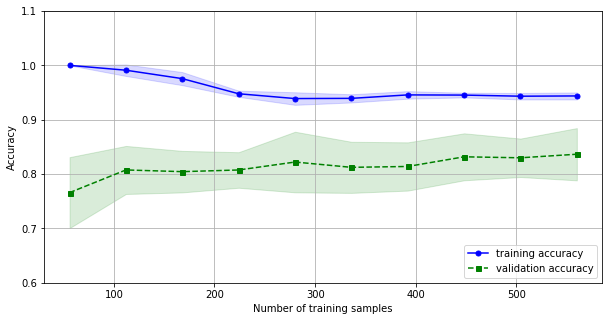

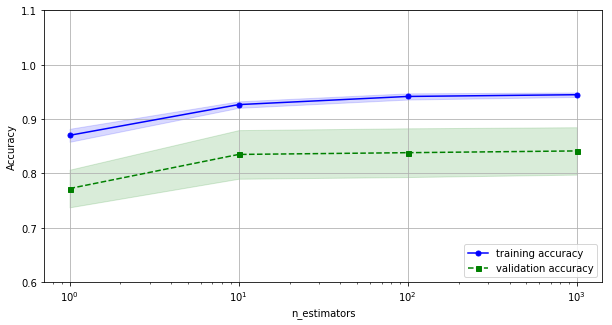

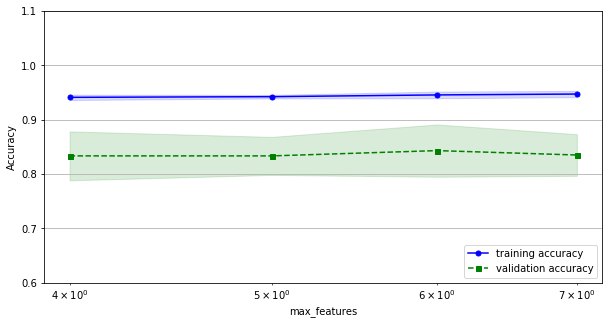

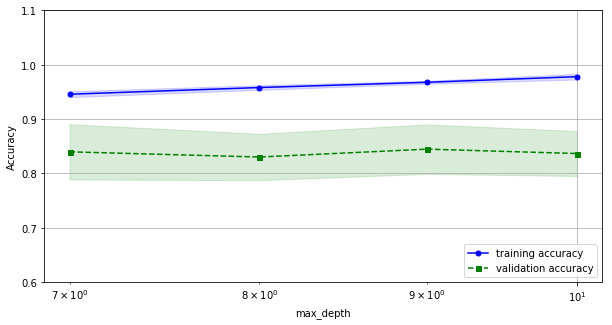

In [5]:
#Plotting graphs
plot_params = {
    'classifier': rf,
    'X_train': X_train,
    'y_train': y_train
}

utils.plot_cv_accuracy(**plot_params)
utils.plot_cv_parameters(**plot_params,
                        param='n_estimators',
                        param_range=[1,10,100,1000])
utils.plot_cv_parameters(**plot_params,
                         param='max_features',
                         param_range=[4,5,6,7])
utils.plot_cv_parameters(**plot_params,
                         param='max_depth',
                         param_range=[7,8,9,10])

#The graphs show grafically what the grid search found.

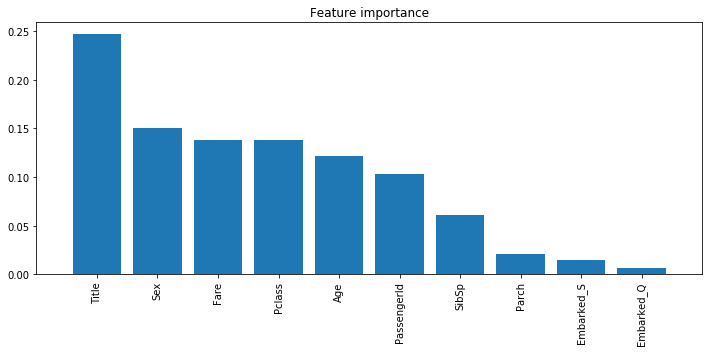

In [6]:
train_copy = train_df.drop(['Survived'], axis=1)
feat_labels = train_copy.columns[0:]
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
# for f in range(X.shape[1]):
#     print("%2d %-*s %f" %(f+1,30,feat_labels[indices[f]],importances[indices[f]]))

plot_params = {
    'X': X_train,
    'importances': importances,
    'indices' : indices,
    'feat_labels':feat_labels[indices]
}
utils.plot_feature_importance(**plot_params)

In [7]:
#Prediction on real test set using random forest
rf.fit(X,y)
survival_results =rf.predict(test_df)
result_df = pd.DataFrame(data={'PassengerId': test_df['PassengerId'].values,
                               'Survived': survival_results})
result_df['Survived'] = [0 if x == False else 1 for x in result_df['Survived']]
#Create output csv file
result_df.to_csv(data_path+"outputs/randomforest_ne_100_maxd_7_maxf_5.csv", index=False)

In [7]:
#TODO :automatic file naming with param values , serialize output for ensamble learning, create plot for feature importancs